# Aerospike Connect for Spark Tutorial for Python
## Tested with Java 8, Spark 2.4.0, and Python 3.7

In [1]:
import os
# If using a non default jar location the below environment variable must be set to the appropriate value
# os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars /Users/kmatty/Documents/Jupyter/SparkConnector/aerospike-spark-assembly-2.4.0.jar pyspark-shell'

In [2]:
import findspark
findspark.init()

In [3]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, ArrayType, IntegerType, MapType, LongType

In [4]:
AS_HOST ="127.0.0.1:3000"
namespace= "test" 

Set up spark and point aerospike db to AS_HOST

In [5]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)
spark.conf.set("aerospike.namespace", namespace)
spark.conf.set("aerospike.seedhost", AS_HOST)

## Create sample data and write to Aerospike database

In [6]:
import random
num_records=1000

schema = StructType( 
    [
        StructField("_id", IntegerType(), True),
        StructField("name", StringType(), True),
        StructField("age", IntegerType(), True),
        StructField("salary",IntegerType(), True)
    ]
)


inputBuf = []
for  i in range(1, num_records) :
         name = "name"  + str(i)
         age = i%100
         salary = 50000 + random.randint(1,50000)
         id_ = i 
         inputBuf.append((id_, name, age,salary))
    
inputRDD = spark.sparkContext.parallelize(inputBuf)
inputDF=spark.createDataFrame(inputRDD,schema)


#Write the Sample Data to Aerospike
inputDF \
.write \
.mode('overwrite') \
.format("com.aerospike.spark.sql")  \
.option("aerospike.seedhost", AS_HOST) \
.option("aerospike.namespace", namespace) \
.option("aerospike.writeset", "py_input_data")\
.option("aerospike.updateByKey", "_id") \
.save()

## Schema in the Spark Connector

-  Aerospike is schemaless, however spark adher to schema. After the schema is decided upon (either through inference or given), data within the bins must honor the types. 

- To infer schema, the connector samples a set of records (configurable through `aerospike.schema.scan`) to decide the name of bins/columns and their types. This implies that the derived schema depends entirely upon sampled records.  

- Note that `__key` was not part of provided schema. So how can one query using `__key`? We can just add `__key` in provided schema with appropriate type. Similarly we can add `__gen` or `__ttl` etc.  
         
      schemaWithPK =  StructType([
                StructField("__key",IntegerType(), False),    
                StructField("id", IntegerType(), False),
                StructField("name", StringType(), False),
                StructField("age", IntegerType(), False),
                StructField("salary",IntegerType(), False)])
                
- We recommend that you provide schema for queries that involve complex data types such as lists, maps, and mixed types. 

## Load data into a DataFrame without specifying any Schema (using connector schema inference)

In [7]:
# Create a Spark DataFrame by using the Connector Schema inference mechanism

loadedDFWithoutSchema = (
    spark.read.format("com.aerospike.spark.sql") \
    .option("aerospike.seedhost",AS_HOST) \
    .option ("aerospike.namespace", namespace) \
    .option("aerospike.keyPath", "/etc/aerospike/features.conf") \
    .option("aerospike.set", "py_input_data") \
    .load()
)


loadedDFWithoutSchema.show()

+-----+--------------------+---------+------------+-------+---+-------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|age|   name|salary|_id|
+-----+--------------------+---------+------------+-------+---+-------+------+---+
| null|[02 50 2D 45 89 D...|340420991|          14|2592000|  4|name604| 53047|604|
| null|[08 50 66 A1 68 1...|340420991|          14|2592000| 10| name10| 66297| 10|
| null|[0B 70 8A F2 9F A...|340420991|          14|2592000| 86|name586| 55387|586|
| null|[13 D0 09 FD 8E E...|340420991|          14|2592000| 77|name477| 87042|477|
| null|[13 50 C4 E1 3F 6...|340420991|          14|2592000| 50| name50| 60270| 50|
| null|[17 B0 1E 54 2C 9...|340420991|          14|2592000| 54|name554| 66669|554|
| null|[18 10 E6 C8 15 6...|340420991|          14|2592000| 64|name964| 95080|964|
| null|[1C 30 1B 8B DC E...|340420991|          14|2592000| 80|name880| 70626|880|
| null|[25 B0 10 82 C7 6...|340420991|          14|2592000| 59|name859| 64936|859|
| nu

## Load data into a DataFrame with user specified schema 

In [8]:
#Data can be loaded with known schema as well.

loadedDFWithSchema=spark \
.read \
.format("com.aerospike.spark.sql") \
.schema(schema) \
.option("aerospike.seedhost",AS_HOST) \
.option("aerospike.featurekey", "/etc/aerospike/features.conf") \
.option ("aerospike.namespace", namespace) \
.option("aerospike.set", "py_input_data").load()

loadedDFWithSchema.show(5)



+---+-------+---+------+
|_id|   name|age|salary|
+---+-------+---+------+
|604|name604|  4| 53047|
| 10| name10| 10| 66297|
|586|name586| 86| 55387|
|477|name477| 77| 87042|
| 50| name50| 50| 60270|
+---+-------+---+------+
only showing top 5 rows



## SparkML with Aerospike

### The purpose of this ML model is to illustrate how data in Aerospike can be used for training and inference using SparkML 
#### A K-Means clustering model is used to create several segments based on age and salary.

In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler


#All machine learning algorithms in Spark take as input a Vector type, which must be a set of numerical values.
assembler = VectorAssembler(
    inputCols=["_id", "age", "salary"],
    outputCol="features")
data_2 = assembler.transform(loadedDFWithSchema)
data_2.show()

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(data_2)

# Make predictions
predictions = model.transform(data_2)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

+---+-------+---+------+--------------------+
|_id|   name|age|salary|            features|
+---+-------+---+------+--------------------+
|604|name604|  4| 53047| [604.0,4.0,53047.0]|
| 10| name10| 10| 66297| [10.0,10.0,66297.0]|
|586|name586| 86| 55387|[586.0,86.0,55387.0]|
|477|name477| 77| 87042|[477.0,77.0,87042.0]|
| 50| name50| 50| 60270| [50.0,50.0,60270.0]|
|554|name554| 54| 66669|[554.0,54.0,66669.0]|
|964|name964| 64| 95080|[964.0,64.0,95080.0]|
|880|name880| 80| 70626|[880.0,80.0,70626.0]|
|859|name859| 59| 64936|[859.0,59.0,64936.0]|
|227|name227| 27| 72720|[227.0,27.0,72720.0]|
|812|name812| 12| 92312|[812.0,12.0,92312.0]|
|780|name780| 80| 51597|[780.0,80.0,51597.0]|
|555|name555| 55| 72318|[555.0,55.0,72318.0]|
|185|name185| 85| 53643|[185.0,85.0,53643.0]|
|221|name221| 21| 74890|[221.0,21.0,74890.0]|
|117|name117| 17| 82151|[117.0,17.0,82151.0]|
|706|name706|  6| 68063| [706.0,6.0,68063.0]|
|358|name358| 58| 81450|[358.0,58.0,81450.0]|
|438|name438| 38| 70774|[438.0,38.

## Writing Sample Complex Data Types (CDT) data into Aerospike

In [10]:
complex_data_json="resources/nested_data.json"
alias=  StructType( [
    StructField("first_name",StringType(), False),
    StructField("last_name",StringType(), False)]
)

name= StructType([
    StructField("first_name",StringType(), False), 
    StructField("aliases",ArrayType(alias), False)]
)
street_adress= StructType([StructField("street_name", StringType(), False), StructField("apt_number", IntegerType(), False)])
address = StructType([StructField("zip", LongType(), False), StructField("street", street_adress, False), StructField("city", StringType(), False)])

workHistory = StructType([StructField ("company_name" , StringType(), False),
                              StructField( "company_address" , address, False),
                              StructField("worked_from", StringType(), False)]
                        )

person= StructType([StructField("name", name, False),
                        StructField("SSN", StringType(), False),
                        StructField("home_address", ArrayType(address), False),
                        StructField("work_history", ArrayType(workHistory), False)]
                  )

cmplx_data_with_schema=spark.read.schema(person).json(complex_data_json)
cmplx_data_with_schema.printSchema()

cmplx_data_with_schema \
.write \
.mode('overwrite') \
.format("com.aerospike.spark.sql")  \
.option("aerospike.seedhost", AS_HOST) \
.option("aerospike.namespace", namespace) \
.option("aerospike.writeset", "complex_input_data") \
.option("aerospike.updateByKey", "name.first_name") \
.save()

root
 |-- name: struct (nullable = true)
 |    |-- first_name: string (nullable = true)
 |    |-- aliases: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- first_name: string (nullable = true)
 |    |    |    |-- last_name: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- home_address: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- zip: long (nullable = true)
 |    |    |-- street: struct (nullable = true)
 |    |    |    |-- street_name: string (nullable = true)
 |    |    |    |-- apt_number: integer (nullable = true)
 |    |    |-- city: string (nullable = true)
 |-- work_history: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- company_name: string (nullable = true)
 |    |    |-- company_address: struct (nullable = true)
 |    |    |    |-- zip: long (nullable = true)
 |    |    |    |-- street: struct (nullable = true)
 |    |    |    |    

## Load Complex Data Types (CDT) into a DataFrame without specifying any schema (using connector schema inference)¶

In [11]:
loadedComplexDFWithoutSchema=spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost", AS_HOST) \
.option("aerospike.keyPath", "/etc/aerospike/features.conf") \
.option ("aerospike.namespace", "test") \
.option("aerospike.set", "complex_input_data") \
.load() 
loadedComplexDFWithoutSchema.printSchema()

root
 |-- __key: string (nullable = true)
 |-- __digest: binary (nullable = false)
 |-- __expiry: integer (nullable = false)
 |-- __generation: integer (nullable = false)
 |-- __ttl: integer (nullable = false)
 |-- SSN: string (nullable = true)
 |-- work_history: array (nullable = true)
 |    |-- element: binary (containsNull = true)
 |-- name: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- home_address: array (nullable = true)
 |    |-- element: binary (containsNull = true)



## Load Complex Data Types (CDT) into a DataFrame with user specified schema 

In [12]:
loadedComplexDFWithSchema=spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost", AS_HOST) \
.option("aerospike.keyPath", "/etc/aerospike/features.conf") \
.option ("aerospike.namespace", "test") \
.option("aerospike.set", "complex_input_data") \
.schema(person) \
.load() 
loadedComplexDFWithSchema.printSchema()
#Please note the difference in types of loaded data in both cases. With schema, we extactly infer complex types.

root
 |-- name: struct (nullable = false)
 |    |-- first_name: string (nullable = false)
 |    |-- aliases: array (nullable = false)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- first_name: string (nullable = false)
 |    |    |    |-- last_name: string (nullable = false)
 |-- SSN: string (nullable = false)
 |-- home_address: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- zip: long (nullable = false)
 |    |    |-- street: struct (nullable = false)
 |    |    |    |-- street_name: string (nullable = false)
 |    |    |    |-- apt_number: integer (nullable = false)
 |    |    |-- city: string (nullable = false)
 |-- work_history: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- company_name: string (nullable = false)
 |    |    |-- company_address: struct (nullable = false)
 |    |    |    |-- zip: long (nullable = false)
 |    |    |    |-- street: struct (nullable = false)
 |  

## Data Exploration with Aerospike 

In [13]:
#Install packages, if not installed.
!pip install numpy 
!pip install matplotlib
!pip install pandas

In [14]:
import pandas
import matplotlib
import matplotlib.pyplot as plt

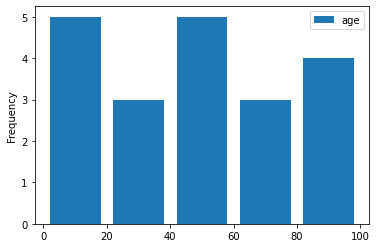

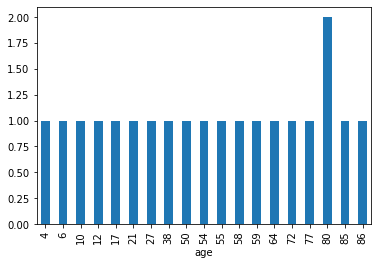

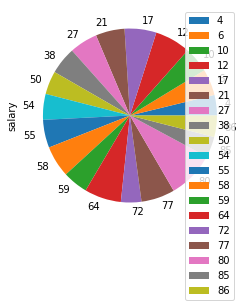

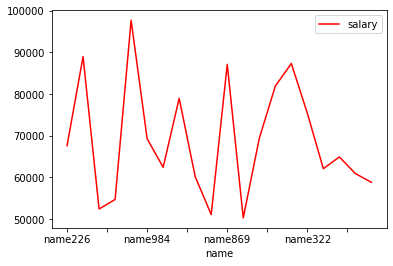

In [15]:
#convert spark df to pandas df
pdf = loadedDFWithSchema.toPandas()
#print(pdf)

#Histogram
pdf[['age']].head(20).plot(kind='hist',bins=[0,20,40,60,80,100],rwidth=0.8)
plt.show()

#Bar graph
pdf.head(20).groupby('age')['name'].nunique().plot(kind='bar')
plt.show()

#pie chart
pdf.head(20).groupby(['age']).sum().plot(kind='pie', y='salary')
plt.show()

#Line Plot
# gca stands for 'get current axis'
ax = plt.gca()
pdf.tail(20).plot(kind='line',x='name',y='salary', color='red', ax=ax)
plt.show()

# Querying Aerospike Data using SparkSQL
#### Things to keep in mind
   1. Queries that involve Primary Key in the predicate trigger aerospike_batch_get()[hyper link: https://www.aerospike.com/docs/client/c/usage/kvs/batch.html] and run extremely fast. For e.g. a query containing `__key` with, with no `OR` between two bins.
   2. All other queries may entail a full scan of the Aerospike DB if they can’t be converted to Aerospike batchget. 

## Queries that include Primary Key in the Predicate

In case of batchget queries we can also apply filters upon metadata columns like `__gen` or `__ttl` etc. To do so, these columns should be exposed through schema (if schema provided). 

In [16]:
batchGet1= spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost", AS_HOST) \
.option("aerospike.featurekey", "/etc/aerospike/features.conf") \
.option ("aerospike.namespace", namespace) \
.option("aerospike.set", "py_input_data") \
.option("aerospike.keyType", "int") \
.load().where("__key = 829") \

batchGet1.show()
#Please be aware ASDB only supports equality test with PKs in primary key query. 
#So, a where clause with "__key >10", would result in scan query!

+-----+--------------------+---------+------------+-------+---+-------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|age|   name|salary|_id|
+-----+--------------------+---------+------------+-------+---+-------+------+---+
|  829|[9A E9 5B 0A 11 6...|340420991|          14|2591946| 29|name829| 55725|829|
+-----+--------------------+---------+------------+-------+---+-------+------+---+



In [17]:
#In this query we are doing *OR* between PK subqueries 
from pyspark.sql.functions import *
somePrimaryKeys= list(range(1,10))
someMoreKeys= list(range(12,14))
batchGet2= spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost",AS_HOST) \
.option("aerospike.featurekey", "/etc/aerospike/features.conf") \
.option ("aerospike.namespace", namespace) \
.option("aerospike.set", "py_input_data") \
.option("aerospike.keyType", "int") \
.load().where((col("__key").isin(somePrimaryKeys)) | ( col("__key").isin(someMoreKeys))) 

batchGet2.show(5)
#We should got in total 'len(somePrimaryKeys) + len(someMoreKeys)' records.

+-----+--------------------+---------+------------+-------+---+------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|age|  name|salary|_id|
+-----+--------------------+---------+------------+-------+---+------+------+---+
|    4|[FE E0 77 E4 17 F...|340420991|          14|2591946|  4| name4| 87361|  4|
|    5|[FF 00 39 4A 07 0...|340420991|          14|2591946|  5| name5| 96477|  5|
|    7|[8B F3 60 83 F9 6...|340420991|          14|2591946|  7| name7| 87085|  7|
|   13|[D7 B4 65 3D FA 4...|340420991|          14|2591946| 13|name13| 67846| 13|
|    3|[75 25 0A 1D C0 4...|340420991|          14|2591946|  3| name3| 92078|  3|
+-----+--------------------+---------+------------+-------+---+------+------+---+
only showing top 5 rows



## Queries that do not include Primary Key in the Predicate

In [18]:
somePrimaryKeys= list(range(1,10))
scanQuery1= spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost", AS_HOST) \
.option ("aerospike.namespace", namespace) \
.option("aerospike.featurekey", "/etc/aerospike/features.conf") \
.option("aerospike.set", "py_input_data") \
.option("aerospike.keyType", "int") \
.load().where((col("__key").isin(somePrimaryKeys)) | ( col("age") >50 ))

scanQuery1.show()

#Since there is OR between PKs and Bin. It will be treated as Scan query. 
#Primary keys are not stored in bins(by default), hence only filters corresponding to bins are honored.  

+-----+--------------------+---------+------------+-------+---+-------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|age|   name|salary|_id|
+-----+--------------------+---------+------------+-------+---+-------+------+---+
| null|[0B 70 8A F2 9F A...|340420991|          14|2591945| 86|name586| 55387|586|
| null|[13 D0 09 FD 8E E...|340420991|          14|2591945| 77|name477| 87042|477|
| null|[17 B0 1E 54 2C 9...|340420991|          14|2591945| 54|name554| 66669|554|
| null|[18 10 E6 C8 15 6...|340420991|          14|2591945| 64|name964| 95080|964|
| null|[1C 30 1B 8B DC E...|340420991|          14|2591945| 80|name880| 70626|880|
| null|[25 B0 10 82 C7 6...|340420991|          14|2591945| 59|name859| 64936|859|
| null|[35 D0 BA A7 35 7...|340420991|          14|2591945| 80|name780| 51597|780|
| null|[3C 80 4A 91 AA 3...|340420991|          14|2591945| 55|name555| 72318|555|
| null|[3D C0 3E 1E 0D C...|340420991|          14|2591945| 85|name185| 53643|185|
| nu

## Query with CDT

In [19]:
#Find people who have had at least 5 jobs in the past
from pyspark.sql.functions import col, size

loadedComplexDFWithSchema \
.withColumn("past_jobs", col("work_history.company_name")) \
.withColumn("num_jobs", size(col("past_jobs")))  \
.where(col("num_jobs") > 4) \
.show(5)

+--------------------+-----------+--------------------+--------------------+--------------------+--------+
|                name|        SSN|        home_address|        work_history|           past_jobs|num_jobs|
+--------------------+-----------+--------------------+--------------------+--------------------+--------+
|[Tami, [[Joseph, ...|001-49-0685|[[23288, [Clark V...|[[Roberts PLC, [4...|[Roberts PLC, Hub...|       5|
|[Chelsea, [[Melis...|465-88-7213|[[49305, [Ward By...|[[Ochoa and Sons,...|[Ochoa and Sons, ...|       5|
|[Jonathan, [[Robe...|526-54-7792|[[71421, [William...|[[Henderson-Shaw,...|[Henderson-Shaw, ...|       5|
|[Gary, [[Cameron,...|825-55-3247|[[66428, [Kim Mil...|[[Bishop, Scott a...|[Bishop, Scott an...|       5|
|[Danielle, [[Mich...|319-30-0983|[[63276, [Bauer C...|[[Powers LLC, [60...|[Powers LLC, Powe...|       5|
+--------------------+-----------+--------------------+--------------------+--------------------+--------+
only showing top 5 rows



## Use Aerospike Spark Connector Configuration properties in the Spark API to improve performance 

  - aerospike.partition.factor: number of logical aerospike partitions [0-15]
  - aerospike.maxthreadcount : maximum number of threads to use for writing data into Aerospike
  - aerospike.compression : compression of java client-server communication
  - aerospike.batchMax : maximum number of records per read request (default 5000)
  - aerospike.recordspersecond : same as java client

#### Other
  - aerospike.keyType : Primary key type hint for schema inference. Always set it properly if primary key type is not string  

See https://www.aerospike.com/docs/connect/processing/spark/reference.html for detailed description of the above properties
